# Final step of data cleaning pipeline

The first part is done in R because the data is packaged as a .Rdata-file from Montero-Manso et al

## Install and import packages

In [1]:
!jupyter notebook --generate-config

^C


In [1]:
%%capture
!pip install pyarrow

In [2]:
import os
import copy
import random
from datetime import datetime
from collections import Counter
from operator import itemgetter
from datetime import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import utils

In [3]:
DATA_DIR = "data"

In [4]:
def mem(df: pd.DataFrame, div=1e9) -> float:
    return df.memory_usage().sum() / div

## Process the meta data for the meta model

In [40]:
mdf = pd.read_feather(os.path.join(DATA_DIR, "m4_meta_cleaned.feather")).set_index("st")
index = mdf.index

In [23]:
mdf.head(n=2)

,n,h,type,period,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,...,snaive_forec_38,snaive_forec_39,snaive_forec_40,snaive_forec_41,snaive_forec_42,snaive_forec_43,snaive_forec_44,snaive_forec_45,snaive_forec_46,snaive_forec_47
st,,,,,,,,,,,,,,,,,,,,,
D1,992,14,4,1,0.997053752897978,9.68357824826554,-0.0254630143470145,0.00746004211146147,-0.517816826939318,0.271950927725247,...,,,,,,,,,,
D2,992,14,4,1,0.99725257328261,9.69910847843249,-0.00607359950061665,0.00455320174435376,-0.523351255720483,0.28357479566569,...,,,,,,,,,,
D3,116,14,4,1,0.873705150792433,2.25628261690727,-0.01473533463979,0.00243863311725713,-0.498711468899847,0.248715064357758,...,,,,,,,,,,
D4,155,14,4,1,0.669916065287868,0.894052875278264,-0.0685662900777497,0.0530404397555249,-0.449965398047466,0.221508474043687,...,,,,,,,,,,
D5,142,14,4,1,0.970663132644678,6.86899804233521,0.110999885559159,0.122275832257416,-0.477236480594683,0.381033490348058,...,,,,,,,,,,


In [24]:
mdf[["n", "h", "type", "period"]] = mdf[["n", "h", "type", "period"]].astype(int)
mdf.iloc[:, 5:] = mdf.iloc[:, 5:].replace(r'^\s*$', np.NaN, regex=True).astype(np.float32)
mdf.dtypes

n                    int32
h                    int32
type                 int32
period               int32
x_acf1              object
                    ...   
snaive_forec_43    float32
snaive_forec_44    float32
snaive_forec_45    float32
snaive_forec_46    float32
snaive_forec_47    float32
Length: 526, dtype: object

In [25]:
mdf.type = mdf.type.astype("category").cat.rename_categories(["Demographic", "Finance", "Industry", "Macro", "Micro", "Other"])

In [26]:
mdf.period = mdf.period.astype("category").cat.rename_categories(["Daily", "Hourly", "Monthly", "Quarterly", "Weekly", "Yearly"])

In [35]:
# Create validation set here
share_val = 0.1
mdf_shuf = utils.shuffle(mdf)

tras = []
vals = []

for p in mdf.period.unique():
    rows = mdf_shuf[mdf_shuf.period == p]
    s = int(rows.shape[0] * share_val)
    tras.append(rows.iloc[:-s, ])
    vals.append(rows.iloc[-s:, ])
    
mtradf = pd.concat(tras, axis=0)
mvaldf = pd.concat(vals, axis=0)

print(mtradf.shape, mvaldf.shape)

(90000, 526) (9995, 526)


In [43]:
mtradf.reset_index().to_feather(os.path.join(DATA_DIR, "m4_meta_train.feather"))
mvaldf.reset_index().to_feather(os.path.join(DATA_DIR, "m4_meta_val.feather"))

## Process the raw training timeseries for LSTM-AE

In [59]:
mtradf = pd.read_feather(os.path.join(DATA_DIR, "m4_meta_train.feather")).set_index("st")
mvaldf = pd.read_feather(os.path.join(DATA_DIR, "m4_meta_val.feather")).set_index("st")

mtradf.shape, mvaldf.shape, mem(mtradf, div=1e6), mem(mvaldf, div=1e6)

((90000, 526), (9995, 526), 189.54044, 21.04991)

In [17]:
rdf = pd.read_feather(os.path.join(DATA_DIR, "m4_series_cleaned.feather")).set_index("st")
columns = rdf.columns
index = rdf.index
rdf = rdf.replace(np.nan, 0)
rdf.head(n=2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V9896,V9897,V9898,V9899,V9900,V9901,V9902,V9903,V9904,V9905
st,,,,,,,,,,,,,,,,,,,,,
D1,1017.1,1019.3,1017.0,1019.2,1018.7,1015.6,1018.5,1018.3,1018.4,1021.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D2,2793.7,2793.8,2803.7,2805.8,2802.3,2795.0,2806.4,2782.2,2780.3,2781.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
rdf = pd.DataFrame(rdf.to_numpy(dtype=np.float32))

In [39]:
rdf.index = index; rdf.columns = columns

NameError: name 'index' is not defined

In [20]:
rdf.insert(0, column="n", value=None)
rdf.insert(1, column="type", value=None)
rdf.insert(2, column="period", value=None)

In [28]:
rdf.n = mdf.n.astype(np.uint16)
rdf.type = mdf.type
rdf.period = mdf.period

In [29]:
# Save the converted df for later
rdf.reset_index().to_feather(os.path.join(DATA_DIR, "m4_series_f32_aug.feather"))

In [30]:
# Make sure the training and validation sets are the same for all parts of the system
rtradf = rdf.loc[mtradf.index, :]
rvaldf = rdf.loc[mvaldf.index, :]
rtradf.shape, rvaldf.shape

((90000, 9908), (9995, 9908))

In [31]:
rtradf.reset_index().to_feather(os.path.join(DATA_DIR, "m4_series_train.feather"))
rvaldf.reset_index().to_feather(os.path.join(DATA_DIR, "m4_series_val.feather"))

## Analyze sparsity of matrix

In [49]:
# Load fullsize, converted df from file
rdf = pd.read_feather(os.path.join(DATA_DIR, "m4_series_f32_aug.feather")).set_index("st")
columns = rdf.columns

In [11]:
lencount = Counter(rdf.n)

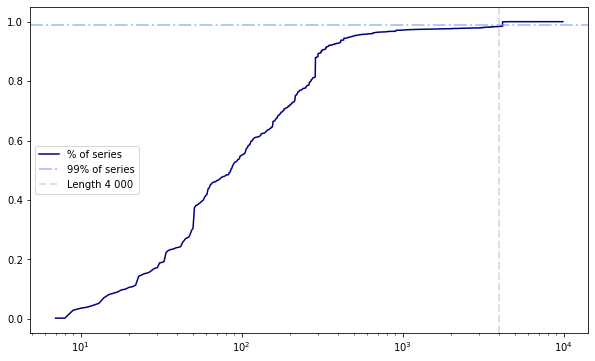

In [12]:
freqs = list(sorted(lencount.items(), key=itemgetter(0)))

x, h = zip(*freqs)
cum = np.array(h).cumsum() / rdf.shape[0]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
# ax.axhline(y=1, linestyle='-.', linewidth=1)
ax.plot(x, cum, label="% of series", color="navy")
ax.axhline(y=0.99, color="cornflowerblue", linestyle='-.', linewidth=2, alpha=.5, label="99% of series")
ax.axvline(x=4e3, color="lightsteelblue", linestyle='--', linewidth=2, alpha=.5, label="Length 4 000")
ax.set_xscale('log')

ax.legend();

## Truncate time-series to last 4000 observations

In [13]:
length = 4000
data = rdf.iloc[:, 3:].to_numpy()

In [15]:
data.dtype

dtype('float32')

In [16]:
out = np.zeros((data.shape[0], length), dtype=np.float32)

In [17]:
out.shape, out.dtype

((99995, 4000), dtype('float32'))

In [18]:
ns = rdf.n.values

In [34]:
for i, (n, d) in enumerate(zip(ns, data)):
    out[i, :n] = d[max(0, n-length):n]

In [55]:
rdf4 = pd.DataFrame(out, index=index, columns=columns[3:length+3])
rdf4.shape

(99995, 4000)

In [56]:
rdf4 = pd.concat([rdf.iloc[:, :3], rdf4], axis=1)

In [57]:
mem(rdf4)
rdf4.head()

,n,type,period,V1,V2,V3,V4,V5,V6,V7,...,V3991,V3992,V3993,V3994,V3995,V3996,V3997,V3998,V3999,V4000
st,,,,,,,,,,,,,,,,,,,,,
D1,992,Macro,Daily,1017.099976,1019.299988,1017.000000,1019.200012,1018.700012,1015.599976,1018.500000,...,1974.099976,1968.099976,1979.500000,1991.199951,1997.699951,1996.099976,2003.500000,2001.099976,2002.699951,2004.099976
D2,992,Macro,Daily,2793.699951,2793.800049,2803.699951,2805.800049,2802.300049,2795.000000,2806.399902,...,2963.600098,2970.500000,3005.399902,3010.000000,3065.300049,3082.100098,3048.600098,3042.699951,3053.699951,3074.899902
D3,116,Macro,Daily,1091.300049,1088.500000,1085.699951,1082.900024,1080.099976,1077.300049,1074.500000,...,969.599976,966.700012,1182.300049,1179.500000,1176.699951,1173.900024,1171.099976,1168.300049,1165.500000,1162.699951
D4,155,Macro,Daily,1092.000000,1078.000000,1064.000000,1050.000000,1036.000000,1022.000000,1008.000000,...,770.000000,742.000000,1260.000000,1232.000000,1204.000000,1176.000000,1148.000000,1120.000000,1092.000000,1610.000000
D5,142,Macro,Daily,2938.629883,2956.439941,2964.409912,2972.409912,3014.969971,3014.229980,3024.080078,...,5619.819824,5622.310059,5649.759766,5659.839844,5662.810059,5665.259766,5667.779785,5698.640137,5701.330078,5703.520020


In [58]:
rdf4.reset_index().to_feather(os.path.join(DATA_DIR, "m4_series_n4_f32.feather"))

In [60]:
# Make sure the training and validation sets are the same for all parts of the system
rtradf4 = rdf4.loc[mtradf.index, :]
rvaldf4 = rdf4.loc[mvaldf.index, :]
rtradf4.shape, rvaldf4.shape

((90000, 4003), (9995, 4003))

In [61]:
rtradf4.reset_index().to_feather(os.path.join(DATA_DIR, "m4_series_n4_f32_train.feather"))
rvaldf4.reset_index().to_feather(os.path.join(DATA_DIR, "m4_series_n4_f32_val.feather"))

## Plot lengths of different series per period type

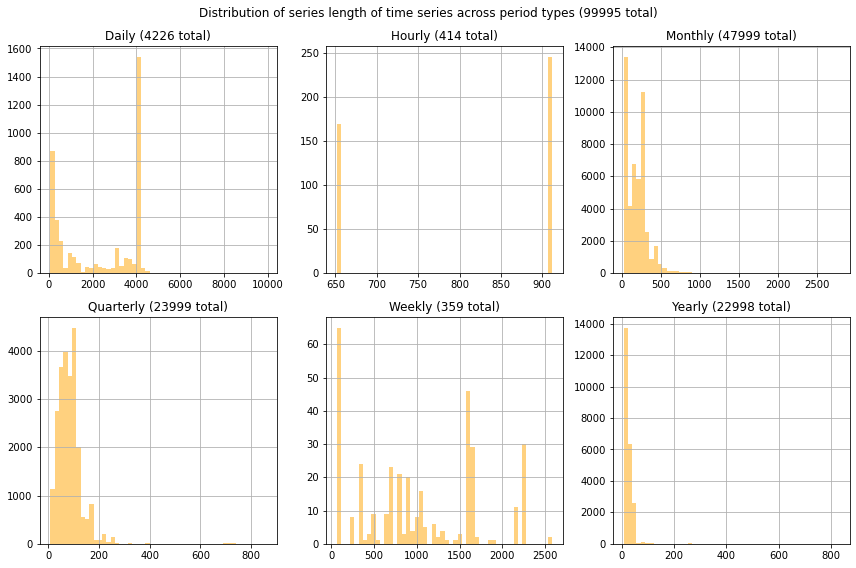

In [46]:
from collections import Counter

fig = plt.figure(figsize=(12, 8))

for i, p in enumerate(df.period.cat.categories, start=1):
    c = Counter()

    for x in df[df.period == p].n.values:
        c[int(x)] += 1
        
    ns = df[df.period == p].n.values
            
    ax = fig.add_subplot(2, 3, i)

    _, bins, patches = ax.hist(list(ns), label=p, bins=50, alpha=0.5, color="orange")
    r = patches[-1]
    # plt.text(r.xy[0] + r.get_width() / 2, r.xy[1] + r.get_height()+20, ">100", ha="center")
    # ax.legend()
    ax.grid()
    ax.set_title(f"{p} ({len(ns)} total)")

fig.suptitle(f"Distribution of series length of time series across period types ({df.shape[0]} total)")
fig.tight_layout()